# Trainers

Designing a training loop for learning a complex dataset.

Almondnet currently run for 30 epochs

In [1]:
import os

import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
from torchvision import datasets, transforms
import time

import lib.histopathology as hcd
from lib.histopathology import AlmondNet

In [2]:
os.chdir('C:/Users/Amod/PycharmProjects/CS184a/histopathology')
print(os.path.isdir('./models'))
DATASET_PATH = 'C:/Users/Amod/PycharmProjects/CS184a/input'

True


In [3]:
# Train/validation split distribution
train_pct = 80
# Training parameters
batch_size = 50
num_epochs = 10
# Optimizer parameters
learning_rate = 1e-4
weight_decay = 0.5
# For mean normalization. Computed over the dataset.
rgb_means = [0.7024860505690291, 0.5462877872713974, 0.6964813026563755]
rgb_stds = [0.23890759190102304, 0.28214205984973445, 0.21625778862043862]

In [4]:
image_dir = os.path.join(DATASET_PATH, 'train')
csv_path = os.path.join(DATASET_PATH, 'train_labels.csv')
pcam_dataset = hcd.PCam(image_dir, csv_path, 
                    transforms.Compose([
                        hcd.transforms.ToClosed(),
                        transforms.RandomVerticalFlip(),
                        transforms.RandomHorizontalFlip(),
                        transforms.RandomRotation(90),
                        transforms.CenterCrop(64),
                        transforms.ToTensor(),
                        hcd.transforms.ToNormalized(rgb_means, rgb_stds)
                    ]))
print(len(pcam_dataset))

220025


In [5]:
train_size = int(train_pct/100 * len(pcam_dataset))
val_size = len(pcam_dataset) - train_size
print(f'Splitting PCam {train_pct}%/{100-train_pct}% into train/validation sets')
# Seed PRNG with the answer to the Ultimate Question of Life, the Universe, and Everything
train_set, val_set = utils.data.random_split(pcam_dataset, 
                                             [train_size, val_size],
                                             generator=torch.Generator().manual_seed(42))

Splitting PCam 80%/20% into train/validation sets


In [6]:
train_loader = utils.data.DataLoader(train_set, batch_size=batch_size, num_workers=0)
val_loader = utils.data.DataLoader(val_set, batch_size=batch_size, num_workers=0)

In [7]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Device:', device)

Device: cuda:0


In [8]:
model = AlmondNet(pretrained=True, freeze_weights=False).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
print(model)
print(str(model))

AlmondNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Linear(in_features=9216, out_features=2048, bias=True)
    (1): ReLU(inplace=True)
    (2): D

In [9]:
trainer = hcd.training.Trainer(model, device, model_dir='./models/')
trainer.load_from_file('./models/AlmondNet_ckpt.pth')

Successfully Loaded File: ./models/AlmondNet_ckpt.pth


In [10]:
losses, accuracies = trainer.train(train_loader, criterion, optimizer, num_epochs=num_epochs)

Epoch [1/10], Step [1000/3521], Loss: 0.393496; Accuracy: 0.860000%
Epoch [1/10], Step [2000/3521], Loss: 0.165709; Accuracy: 0.920000%
Epoch [1/10], Step [3000/3521], Loss: 0.290053; Accuracy: 0.860000%
------------[Loss = 0.230045; Accuracy = 0.909472%]------------
Successfully saved checkpoint file to: ./models/AlmondNet_ckpt.pth
Epoch [2/10], Step [1000/3521], Loss: 0.410618; Accuracy: 0.840000%
Epoch [2/10], Step [2000/3521], Loss: 0.148507; Accuracy: 0.940000%
Epoch [2/10], Step [3000/3521], Loss: 0.323962; Accuracy: 0.880000%
------------[Loss = 0.218791; Accuracy = 0.912721%]------------
Successfully saved checkpoint file to: ./models/AlmondNet_ckpt.pth
Epoch [3/10], Step [1000/3521], Loss: 0.443815; Accuracy: 0.840000%
Epoch [3/10], Step [2000/3521], Loss: 0.130235; Accuracy: 0.940000%
Epoch [3/10], Step [3000/3521], Loss: 0.378407; Accuracy: 0.840000%
------------[Loss = 0.213504; Accuracy = 0.914388%]------------
Successfully saved checkpoint file to: ./models/AlmondNet_ckpt

<Figure size 432x288 with 0 Axes>

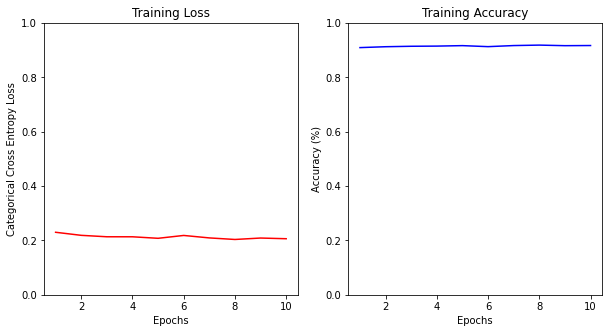

In [13]:
plt.subplots_adjust(wspace=1)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title('Training Loss')
ax[0].plot(list(range(1,len(losses)+1)), losses, 'r-')
ax[0].set_ylabel('Categorical Cross Entropy Loss')
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Epochs')
ax[1].set_title('Training Accuracy')
ax[1].plot(list(range(1,len(accuracies)+1)), accuracies, 'b-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs')
plt.savefig('C:/Users/Amod/PycharmProjects/CS184a/Results Images/25-35eAlmondNetWithClosedRR90.jpg')

In [14]:
score, accuracy, loss = trainer.evaluate(val_loader, criterion)
print('Evaluating AlmondNet on Validation set:')
print('F1-Score:', score)
print('Accuracy:', accuracy)
print('Loss:', loss)

Evaluating AlmondNet on Validation set:
F1-Score: 0.8953518123167423
Accuracy: 0.9163504147255972
Loss: 210.1514426395297


# Test batches of 200

In [ ]:
        model.train()
        since = time.time()
        num_steps = len(train_loader)
        losses = []
        accuracies = []
        for epoch in range(1, 26):
            epoch_accuracy = 0.0
            epoch_loss = 0.0
            for i, (images, labels) in enumerate(train_loader, start=1):
                images = images.to(device)
                labels = labels.to(device)
                # Generate prediction and evaluate
                outputs = model(images)
                labels = labels.long().flatten()
                loss = criterion(outputs, labels)
                # Backpropagate loss and update weights
                optimizer.zero_grad()
                loss.backward()
                # Compute accuracy on this batch
                predictions = torch.argmax(outputs, dim=1)
                accuracy = (predictions == labels).sum().item() / len(labels)
                optimizer.step()
                # Compute running average of epoch loss
                epoch_loss = (epoch_loss * (i-1) + loss.item()) / i
                # Compute running average of accuracy
                epoch_accuracy = (epoch_accuracy * (i-1) + accuracy) / i
                # Print progress every 100 batches
                # print(f'Epoch [{epoch}/2], Step [{i}/{num_steps}], '
                          # f'Loss: {loss.item():.6f}; Accuracy: {accuracy:.6f}%')
                # Print metrics for the current epoch
                if i % 200 == 0:
                    break
            losses.append(epoch_loss)
            accuracies.append(epoch_accuracy)
            print(f'------------[Loss = {epoch_loss:6f}; Accuracy = {epoch_accuracy:6f}%]------------')
        # Print training time
        time_elapsed = time.time() - since
        print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
        print(losses)
        print(accuracies)

In [ ]:
plt.subplots_adjust(wspace=1)
fig, ax = plt.subplots(1,2, figsize=(10,5))
ax[0].set_title('Training Loss')
ax[0].plot(list(range(1,len(losses)+1)), losses, 'r-')
ax[0].set_ylabel('Categorical Cross Entropy Loss')
ax[0].set_ylim(0, 1)
ax[0].set_xlabel('Steps')
ax[1].set_title('Training Accuracy')
ax[1].plot(list(range(1,len(losses)+1)), accuracies, 'b-')
ax[1].set_ylabel('Accuracy (%)')
ax[1].set_ylim(0, 1)
ax[1].set_xlabel('Epochs')
plt.savefig(fname='C:/Users/Amod/PycharmProjects/CS184a/Results Images/AlmondNetWithClosedRR90.jpg')

# Evaluate a saved model

In [ ]:
print(model.__class__.__name__ + '_ckpt.pth')
trainer = hcd.training.Trainer(model, train_loader, model_dir='./models/')
trainer.load_checkpoint()

In [ ]:
score, accuracy, loss = hcd.evaluation.evaluate(model, val_loader, device, criterion)
print('Evaluating AlmondNet on Validation set:')
print('F1-Score:', score)
print('Accuracy:', accuracy)
print('Loss:', loss)

In [15]:
torch.save(model.state_dict(), './models/25-35eAlmondNetWithClosedRR90.pth.tar')